# Libraries

In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import copy as cp


import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path
import more_itertools as mit

import seaborn as sns

In [5]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Modules

In [ ]:
# import libs.gfitflex as fitlib
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)

gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)

sys.path.append(parent_dir)

module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

In [8]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# Read table DR3

In [ ]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [26]:
field_ids = df['sbid'].unique()
nfields = len(field_ids)
print(f'Number of fields: {nfields}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [27]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


# Select Fields

In [ ]:
field_dict = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726', 'J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

# Select a field
fieldn = 8

field_id, fg_abs_filename, some_srcs = field_dict.get(fieldn, None)
field = 'sb' + str(field_id)
fg_abs_filename = hires_data / fg_abs_filename
source = some_srcs[0]
print(field_id, field)
print('fg abs filename: ', fg_abs_filename)
print('source: ', source)

# Images of the field
m0_file = hires_em_data / f'LMC-{fieldn}_fg_askap_parkes_PBC_K_full_mom0.fits'
data_file = hires_em_data / f'LMC-{fieldn}_fg_askap_parkes_PBC_K_full.fits'

# Field df
field_df = df[df['sbid'] == field_id]
n_field_srcs, ncols = field_df.shape
field_src_list = field_df['comp_name'].values
print(f'Field: {field_id}, n_sources: {n_field_srcs}')

field_src_ra = field_df['ra'].values
field_src_dec = field_df['dec'].values

field_src_gl = field_df['glon'].values
field_src_gb = field_df['glat'].values

print(f'Number of rows {n_field_srcs},\n Number of columns: {ncols}')
field_df.head(5)

In [32]:
field_df = df[df['sbid'] == field_id]
n_field_srcs, ncols = field_df.shape
field_src_list = field_df['comp_name'].values
print(f'Field: {field_id}, n_sources: {n_field_srcs}')

field_src_ra = field_df['ra'].values
field_src_dec = field_df['dec'].values

field_src_gl = field_df['glon'].values
field_src_gb = field_df['glat'].values

print(f'Number of rows {n_field_srcs},\n Number of columns: {ncols}')
field_df.head(5)

Field: 33047, n_sources: 290
Number of rows 290,
 Number of columns: 33


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
317,7,J053528-691612,SB33047_component_2a,83.866885,-69.270004,279.703720,-31.936985,A,720.179993,848.950012,0.003531,0.005301,0.420186,15.470555,1.025511,114.0,0.605325,263.765641,0.501989,0.012455,True,True,5.140,4.015,77.050003,3.360408e+21,False,-0.003089,M000+02,33047,33047,True,False
318,8,J060005-703833,SB33047_component_3a,90.021003,-70.642513,281.085305,-29.719595,B,343.647003,358.765991,0.002825,0.009905,0.103610,2.262491,1.031758,114.0,0.928148,-2.631224,0.074564,0.013154,True,False,4.805,3.810,76.040001,2.859386e+20,False,0.001083,M000+02,33047,33047,True,False
319,12,J060006-703853,SB33047_component_3e,90.025923,-70.648065,281.091616,-29.717740,B,27.239000,30.006001,0.000290,0.071483,0.486128,1.129329,1.228301,70.0,0.742173,238.733987,0.298173,0.092079,False,False,5.115,3.770,80.519997,2.859386e+20,False,-0.002890,M000+02,33047,33047,False,False
320,14,J051832-693521,SB33047_component_4a,79.636485,-69.589402,280.371000,-33.349307,A,248.936996,258.369995,0.002268,0.010292,0.608874,16.561517,1.034671,99.0,0.425797,218.299642,0.853794,0.025342,True,True,4.955,3.670,77.690002,1.885979e+21,False,-0.001576,M000+02,33047,33047,True,False
321,17,J060111-703609,SB33047_component_5a,90.297269,-70.602632,281.035396,-29.629529,B,331.528015,370.898010,0.002316,0.010888,0.141659,2.151169,1.044955,103.0,0.903295,-7.481510,0.101706,0.014532,True,False,4.990,3.925,81.220001,2.976061e+20,False,0.001399,M000+02,33047,33047,True,False


In [33]:
print(field_df.shape)
print(field_df.columns)

(290, 33)
Index(['id', 'comp_name', 'component_id', 'ra', 'dec', 'glon', 'glat',
       'rating', 'flux_peak', 'flux_int', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'min_opacity', 'vel_min_opacity', 'peak_tau', 'e_peak_tau',
       'has_mw_abs', 'has_other_abs', 'semi_maj_axis', 'semi_min_axis', 'pa',
       'n_h', 'noise_flag', 'continuum_slope', 'field', 'all_sbids', 'sbid',
       'mw_detection', 'saturated'],
      dtype='object')


## Read GaussFit results

In [ ]:
# VLSR finer grid
vlsr_grid = np.arange(-100., 100., 0.1)

In [55]:
# Select a field
print(field_id)
print(field)

33047
sb33047


In [ ]:
gfit_result_field_path = hires_results / field
print(gfit_result_field_path)
field_sources = glob.glob(str(gfit_result_field_path / '*.pkl'))
len(field_sources)

# Read the result from Gaussian fit

In [72]:
## Plot the results after the fit to EM profile
 #
 # params 
 # params 
 # params 
 # params 
 #
 # return 
 #        
 #
 # version 07/2018
 # author Nguyen Van Hiep ##
def plot_gfit1(src,
                         src_id,
                         field,
                         src_info,
                         tb,
                         ncnm,
                         nwnm,
                         cnm_order,
                         params,
                         vlsr_gaskap,
                         xvel,
                         cenwnm,
                         hgtwnm,
                         widwnm,
                         tb_tot_fit,
                         tb_wnm_tot,
                         tb_cnm_tot,
                         tb_fit_newgrid,
                         tb_wnm_tot_newgrid,
                         tb_cnm_tot_newgrid,
                         npi,
                         dist,
                         emt,
                         emt_std,
                         emt_fit,
                         emt_fit_new_grid,
                         hgtcnm,
                         cencnm,
                         widcnm,
                         tspin_cnm,
                         sigtspin_cnm,
                         fcnm,
                         sigfcnm,
                         Rfactor,
                         sigRfactor,
                         vrange=None,
                         figpath=None
                        ):
    
    # plot data and the absorption fit
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,15), sharex=True)

    ## Add one subplot in this panel for residuals
    divider = make_axes_locatable(ax1)
    axres   = divider.append_axes('bottom', size='25%', pad=0, sharex=ax1)
    ax1.figure.add_axes(axres)
    # axres.spines['bottom'].set_visible(False)
    
    lines0 = []
    l1, = ax1.plot(vlsr_gaskap, tb, 'k-', lw=1.5, label=r'GASKAP emission')
    lines0.append(l1)
    l1, = ax1.plot(xvel, tb_fit_newgrid, 'r-', lw=2, label=r'Total emission fit')
    lines0.append(l1)
    l1, = ax1.plot(xvel, tb_wnm_tot_newgrid, color='darkviolet', ls='-', lw=1.7, label=r'$T_\mathrm{B,WNM}$')
    lines0.append(l1)
    l1, = ax1.plot(xvel, tb_cnm_tot_newgrid, 'b-', lw=1.7, label=r'$T_\mathrm{B,CNM}$')
    lines0.append(l1)
    
    lines = []
    for wnmi, (wcen, whgt, wwid) in enumerate(zip(cenwnm, hgtwnm, widwnm)):
        label_wnm = 'WNM coponents: \n'+r'[$T_\mathrm{b,peak}$, $V_0$, $\Delta V_\mathrm{FWHM}$]' if wnmi == 0 else ''
        wnmline, = ax1.plot(vlsr_gaskap, fitlibs.gaussfunc(vlsr_gaskap, 0., [whgt], [wcen], [wwid]), 'k:', lw=1.8, label=label_wnm)
        lines.append(wnmline)
    
    for wnmi, (wcen, whgt, wwid) in enumerate(zip(cenwnm, hgtwnm, widwnm)):
        whgt = np.round(whgt, 1)
        wcen = np.round(wcen, 1)
        wwid = np.round(wwid, 1)
        ploti, = ax1.plot([], [], '', label=f'{str(wnmi)}) [{whgt}, {wcen}, {wwid}]')
        lines.append(ploti)
        ploti.set_visible(False)
    
    ploti, = ax1.plot([], [], '',
                      label='\n' + r'$f_\mathrm{CNM}$' + f': {np.round(fcnm,2)}' + r'$\pm$' + f'{np.round(sigfcnm,2)}')
    lines.append(ploti)
    ploti.set_visible(False)
    
    ploti, = ax1.plot([], [], '',
                      label=r'$\mathcal{R}_\mathrm{HI}$: ' + f'{np.round(Rfactor,2)}' + r'$\pm$' + f'{np.round(sigRfactor,2)}')
    lines.append(ploti)
    ploti.set_visible(False)

    ax1.set_ylim(-4.5, np.max(tb)+0.5)
    
    ax1.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=30)
    ax1.tick_params(axis='x', labelsize=25)
    ax1.tick_params(axis='y', labelsize=25)
    ax1.tick_params(axis='y',
                    direction='out',
                    length=8,
                    width=2,
                    colors='k',
                    grid_color='k',
                    grid_alpha=0.5)
    ax1.tick_params(axis='x',
                    direction='in',
                    length=8,
                    width=2,
                    colors='k',
                    grid_color='k',
                    grid_alpha=0.5)
    
    first_legend = ax1.legend(handles=lines0, loc='upper left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=22.5)
    ax1.add_artist(first_legend)
    ax1.legend(handles=lines, loc='upper right', fancybox=False, framealpha=0.925, labelcolor='k', fontsize=19.)
    ax1.grid(c='gray', ls=':', lw=0.25)
    
    # Axe - residuals
    em_residuals = tb - tb_tot_fit
    
    min_res = em_residuals.min()
    max_res = em_residuals.max()
    ylim_em_res_diff = max_res - min_res
    ylim_em_res = [min_res-0.5*ylim_em_res_diff, max_res+0.5*ylim_em_res_diff]
    
    noise_idx = np.where(vlsr_gaskap < -40.)[0]
    sigtb = np.std(tb[noise_idx])
    axres.plot(vlsr_gaskap, vlsr_gaskap*0.-sigtb, color='k', ls=':', lw=1.5, label=r'$1\sigma$' + f' ({(round(sigtb,1))} K)')
    axres.plot(vlsr_gaskap, vlsr_gaskap*0.+sigtb, color='k', ls=':', lw=1.5, label='')
    axres.plot(vlsr_gaskap, em_residuals, color='k', ls='--', label='Residuals [K]')
    
    axres.set_ylabel('Residuals', fontsize=20)
    axres.tick_params(axis='x',  which='both', bottom=True, top=False, labelbottom=False, labelsize=18)
    axres.tick_params(which='both', width=2)
    axres.tick_params(axis='x', labelsize=15)
    axres.tick_params(axis='y', labelsize=15)
    axres.tick_params(which='major', length=8)
    axres.tick_params(which='minor', length=3)
    axres.grid(c='gray', ls=':', lw=0.25)
    axres.spines['top'].set_linewidth(0.5)
    
    axres.set_ylim(ylim_em_res)
    axres.legend(loc='upper left', fancybox=False, framealpha=0.925, labelcolor='k', fontsize=16)
    ## End - Subplot 1

    
    
    
    ## Absorption
    ## Add new subplot in this panel for Residuals
    divider = make_axes_locatable(ax2)
    axres   = divider.append_axes('top', size='25%', pad=0, sharex=ax1)
    ax2.figure.add_axes(axres)
    ##

    lines0 = []
    l1, = ax2.plot(vlsr_gaskap, emt, 'k-', lw=1, label='GASKAP absorption')
    lines0.append(l1)
    l1, = ax2.plot(xvel, emt_fit_new_grid, color='r', lw=2, label='Absorption fit')
    lines0.append(l1)
    

    for ic, (chgt, ccen, cwid) in enumerate(zip(hgtcnm, cencnm, widcnm)):
        clabel = r"CNM components:" "\n" r"[${\tau}_\mathrm{peak}$, $V_\mathrm{0}$, $\Delta V_\mathrm{FWHM}$, $T_\mathrm{s}$]" if ic == 0 else ''
        ctau = chgt*np.exp(- ( (xvel-ccen)/(0.6005612*cwid) )**2)
        ploti, = ax2.plot( xvel, np.exp(-ctau), 'b:', lw=1.8, label=clabel)
        lines0.append(ploti)
    
    infogr = zip(hgtcnm, cencnm, widcnm, tspin_cnm, sigtspin_cnm)
    for ic, (chgt, ccen, cwid, cts, csigts) in enumerate(infogr):
        chgt = np.round(chgt, 1)
        ccen = np.round(ccen, 1)
        cwid = np.round(cwid, 1)
        cts  = np.round(cts, 1)
        csigts = np.round(csigts, 1)
        ploti, = ax2.plot([], [], '', label=f"[{chgt}, {ccen}, {cwid}, " + r'$T_\mathrm{s}$' + f'= {cts}' + r'$\pm$' + f'{csigts} K]') # {str(ic)})
        lines0.append(ploti)
        ploti.set_visible(False)
    
    lines = []
    l1, = ax2.plot(vlsr_gaskap, 1.+emt_std, 'k--', lw=1.5, label=r'$1\sigma$ envelope')
    lines.append(l1)
    ax2.plot(vlsr_gaskap, 1.-emt_std, 'k--', lw=1.5, label=r'')
    l1,  = ax2.plot(vlsr_gaskap, 1.-3.*emt_std, 'k-.', lw=1.5, label=r'$3\sigma$ detection threshold')
    lines.append(l1)
    ax2.fill_between(vlsr_gaskap, 1.-emt_std, 1.+emt_std, color='grey', alpha=0.3, facecolor='grey', label=r'')
    
    ax2.set_ylabel(r'$e^{-\tau}$', fontsize=33)
    ax2.set_xlabel(r'VLSR [km s$^{-1}$]', fontsize=30)
    ax2.tick_params(axis='x', labelsize=25)
    ax2.tick_params(axis='y', labelsize=25)
    ax2.tick_params(direction='out', length=8, width=2, colors='k', grid_color='k', grid_alpha=0.5)
    
    
    ax2.set_xlim(-50., 50.)
    ax2.set_ylim(0.625, 1.07)


    ax2.grid(c='gray', ls=':', lw=0.25)
    first_legend = ax2.legend(handles=lines0, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=17.5)
    ax2.add_artist(first_legend)

    ax2.legend(handles=lines, loc='lower right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=21.3)
    
    # Axe - residuals
    emt_residuals = emt - emt_fit
    axres.plot(vlsr_gaskap, -emt_std, color='k', ls=':', lw=1.5, label='')
    axres.plot(vlsr_gaskap, emt_std, color='k', ls=':', lw=1.5, label='')
    axres.plot(vlsr_gaskap, emt_residuals, color='k', ls='--', label='$Residuals$')

    axres.set_ylabel(r'$\mathrm{Residuals}$', fontsize=22)

    axres.tick_params(axis='x',  which='both', bottom=True, top=False, labelbottom=False, labelsize=15)
    axres.tick_params(axis='x', labelsize=15)
    axres.tick_params(axis='y', labelsize=15)
    axres.tick_params(which='both', width=2)
    axres.tick_params(which='major', length=8)
    axres.tick_params(which='minor', length=3)
    axres.grid(c='gray', ls=':', lw=0.25)
    axres.spines['bottom'].set_visible(False)
    ## End - Subplot 2


    # set the spacing between subplots
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=None,
                        hspace=0.05
                    )

    plt.show()
    plt.clf() 
    plt.close('all')
# End - 

In [59]:
# VLSR finer grid
xvel = np.arange(-100., 100., 0.1)

Loop through all MW sightlines having absorption dectection

In [104]:
def _run(df, field_id, src):    
    # Infor of the source
    src_info = fcn.get_source_info_by_name(df, src)
    
    # Galactic coordinates
    src_gl = src_info['glon']
    src_gb = src_info['glat']
    
    src_path = gfit_result_field_path / (src + '.pkl')
    with open(src_path, 'rb') as xfile:
        ret = pickle.load(xfile)
    xfile.close()
    
    src = ret['source']
    field = ret['field']
    field_id = ret['field_id']
    pkl_file = ret['pkl_file']
    src_info = ret['src_info']
    
    # Infor of the source
    field_id = field_id
    field    = field

    # Load pickle infor
    with open(pkl_file, 'rb') as pickle_file:
        neigbour_spectra_info = pickle.load(pickle_file)
    dist  = neigbour_spectra_info['neighbour_distances']
    
    
    # Emission profiles
    vlsr = ret['vlsr']
    Npix = ret['n_profiles']
    nchan = ret['nchans']
    em_spectra = ret['EM_profiles'].T # in MW vlsr range

    
    # ABSORPTION FIT RESULTS
    hgtcnm = ret['hgtcnm']
    cencnm = ret['cencnm']
    widcnm = ret['widcnm']
    ncnm = ret['ncnm']

    xvel = ret['vlsr_fine_grid']
    tau_fit = ret['tau_fit']
    tau_fit_new_grid = ret['tau_fit_fine_grid']
    emt_fit = ret['emt_fit']
    emt_fit_new_grid = ret['emt_fit_fine_grid']

    vlsr_gaskap = ret['vlsr_gaskap']
    emt = ret['emt']
    sigemt = ret['sigemt']
    
    
    # e(-tau)
    tau_fit = 0.
    tau_fit_new_grid = 0.
    for (taui,ceni,widi) in zip(hgtcnm, cencnm, widcnm):
        tau_fit = tau_fit + taui*np.exp(- ( (vlsr_gaskap-ceni)/(0.6005612*widi) )**2)
        tau_fit_new_grid = tau_fit_new_grid + taui*np.exp(- ( (xvel-ceni)/(0.6005612*widi) )**2)
    # Endfor
    emt_fit = np.exp(-tau_fit)
    emt_fit_new_grid = np.exp(-tau_fit_new_grid)

    # Plot
    fitlibs.plot_absorption_fit(field,
                        src,
                        src_info,
                        vlsr_gaskap,
                        xvel,
                        em_spectra,
                        emt,
                        sigemt,
                        emt_fit,
                        emt_fit_new_grid,
                        hgtcnm,
                        cencnm,
                        widcnm
                       )
    
    
    # EMISSION FIT RESULTS
    print('From EMISSION FIT... \n')
    emfit_ret = ret['emfit']
    for key, val in emfit_ret.items():
        npi = int(key)
        tb  = em_spectra[npi]

        # Read data of the emission fit  
        nwnm = val['nwnm']
        hgtwnm0 = val['hgtwnm0']
        cenwnm0 = val['cenwnm0']
        widwnm0 = val['widwnm0']

        hgtwnm = val['hgtwnm']
        cenwnm = val['cenwnm']
        widwnm = val['widwnm']
        tb_wnm_tot = val['tb_wnm_tot']
        tb_cnm_tot = val['tb_cnm_tot']
        params = val['params']
        tb_tot_fit = val['tb_tot_fit']
        tdata_final = val['tdata_final']
        
        tb_tot_fit_newgrid = val['tb_tot_fit_newgrid']
        tb_cnm_tot_newgrid = val['tb_cnm_tot_newgrid']
        tb_wnm_tot_newgrid = val['tb_wnm_tot_newgrid']

        tspin_final = val['tspin_final']
        sigtspin_final = val['sigtspin_final']
        cnm_order = val['cnm_order']

        fcnm = val['fcnm']
        sigfcnm = val['sigfcnm']
        Rfactor = val['Rfactor']
        sigRfactor = val['sigRfactor']
        
        ## Plot
        plot_gfit1(src,
                             npi,
                             field,
                             src_info,
                             tdata_final,
                             ncnm,
                             nwnm,
                             cnm_order,
                             params,
                             vlsr_gaskap,
                             xvel,
                             cenwnm,
                             hgtwnm,
                             widwnm,
                             tb_tot_fit,
                             tb_wnm_tot,
                             tb_cnm_tot,
                             tb_tot_fit_newgrid,
                             tb_wnm_tot_newgrid,
                             tb_cnm_tot_newgrid,
                             npi,
                             round(dist[npi],2),
                             emt,
                             sigemt,
                             emt_fit,
                             emt_fit_new_grid,
                             hgtcnm,
                             cencnm,
                             widcnm,
                             tspin_final,
                             sigtspin_final,
                             fcnm,
                             sigfcnm,
                             Rfactor,
                             sigRfactor,
                             vrange=None,
                             figpath=''
                            )
    # Endfor - emission profiles
# Endfor - sources
print('-->')

-->


# Run

In [97]:
print(field_id)
print(field)
len(field_src_list)

38466
sb38466


261

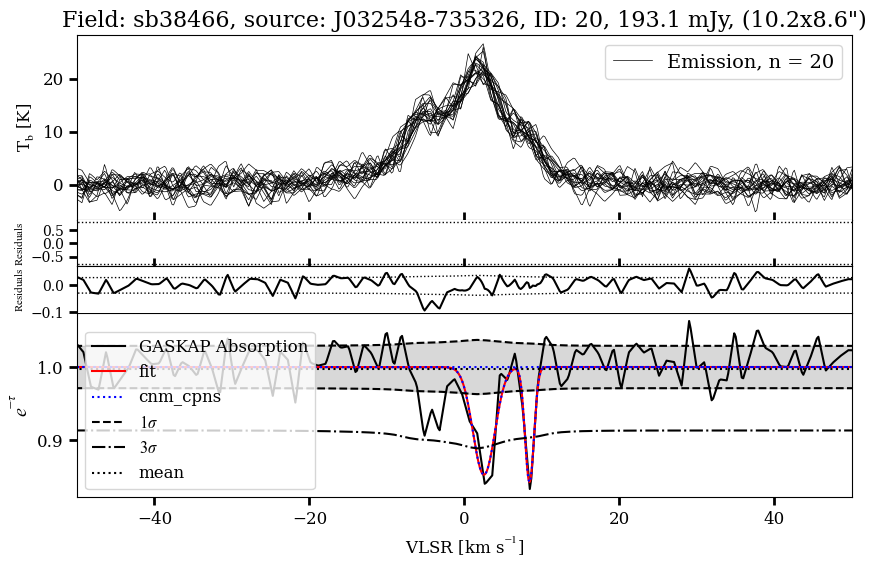

From EMISSION FIT... 

Emission profile ID: 16


/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_79548/2808554987.py:124: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7faf70353af0> has a label of '_child5' which cannot be automatically added to the legend.
  ax1.legend(handles=lines, loc='upper right', fancybox=False, framealpha=0.925, labelcolor='k', fontsize=19.)
/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_79548/2808554987.py:212: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fafa23ed2a0> has a label of '_child3' which cannot be automatically added to the legend.
  first_legend = ax2.legend(handles=lines0, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=17.5)


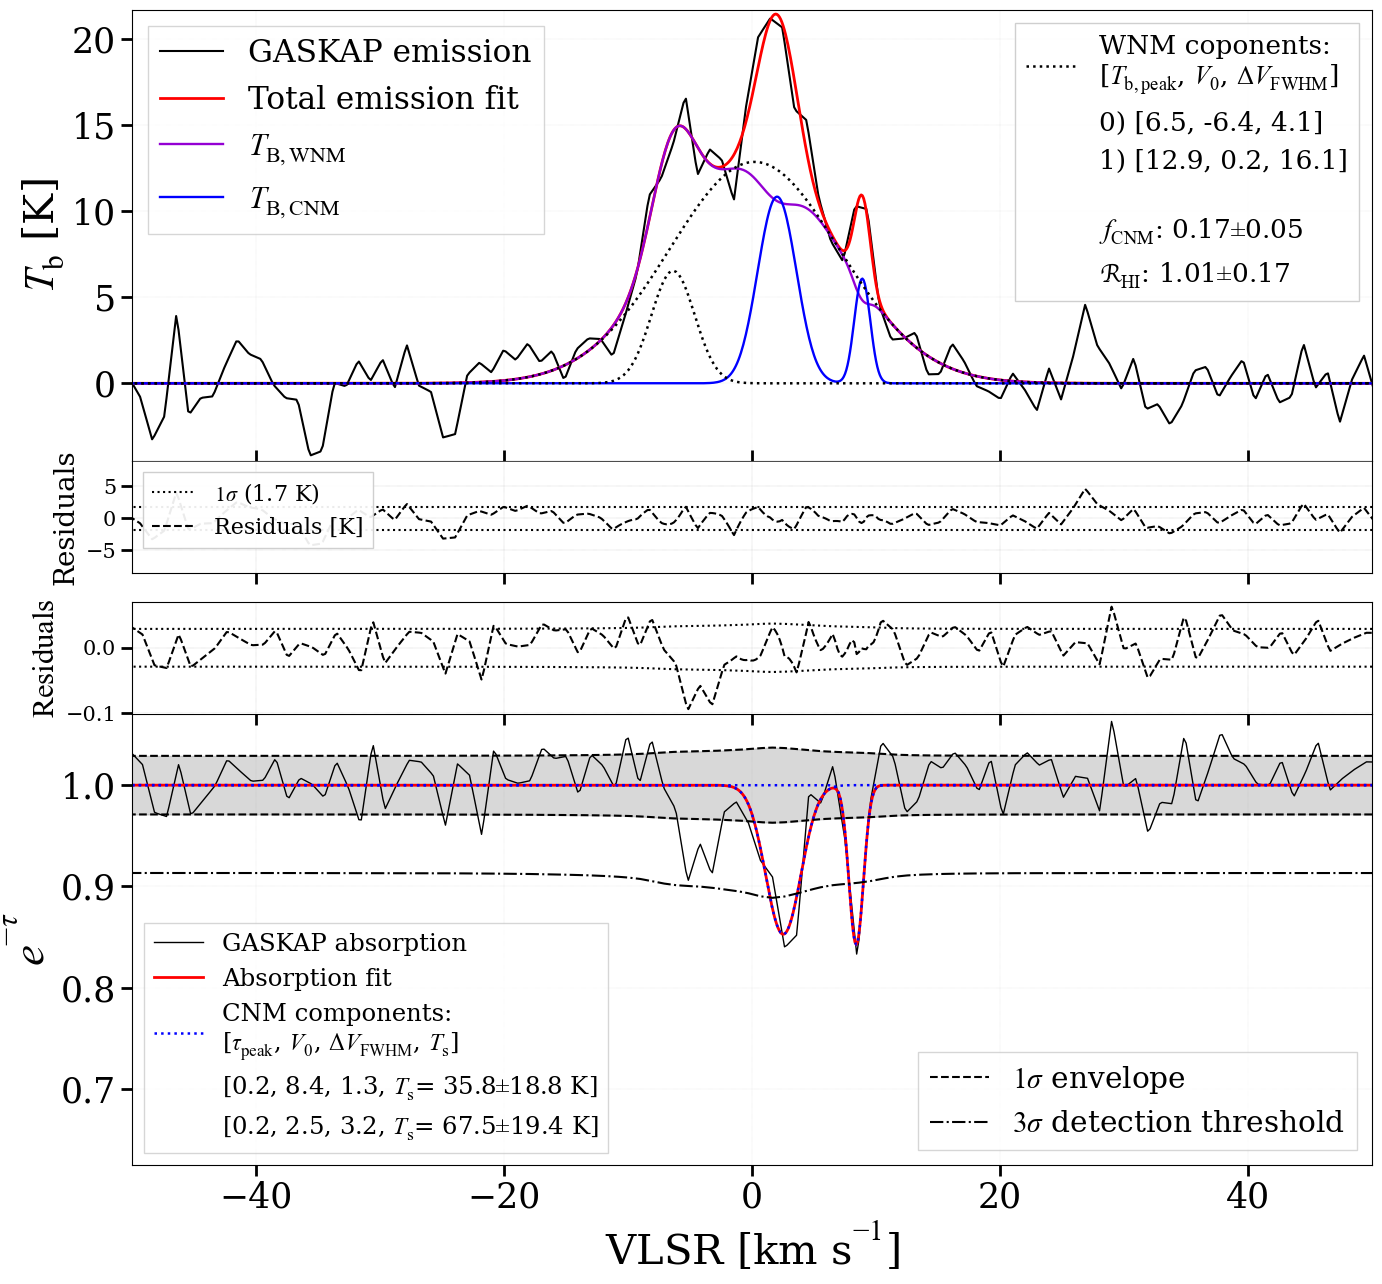

In [105]:
# Example plot: J054427-715528 field 4
# Example, adding 1 WNM; J032548-735326 J032548-73532
src = 'J032548-735326'
_run(df, field_id, src)